<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task7(Lite)_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Прогнозирование акций Лукойл**

**1. Импорт библиотек**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import math
from google.colab import drive
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input, concatenate, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import StandardScaler, MinMaxScaler

drive.mount('/content/drive')

Mounted at /content/drive


**2. Загрузка базы данных**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!rm -R '/content/texts' #remove texts directory
!unzip -q '/content/drive/MyDrive/Colab Notebooks/shares.zip' -d '/content/texts' #unzip to created `texts` directory
base_data = pd.read_csv('/content/texts/18_19.csv', sep=';')
base_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
rm: cannot remove '/content/texts': No such file or directory


,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
base_data16 = pd.read_csv('/content/texts/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/texts/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]
print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [ ]:
# Объединяем базы из двух файлов
data = pd.concat([data16_17,data18_19]) 
data = np.array(data) 
data.shape      


(481872, 5)

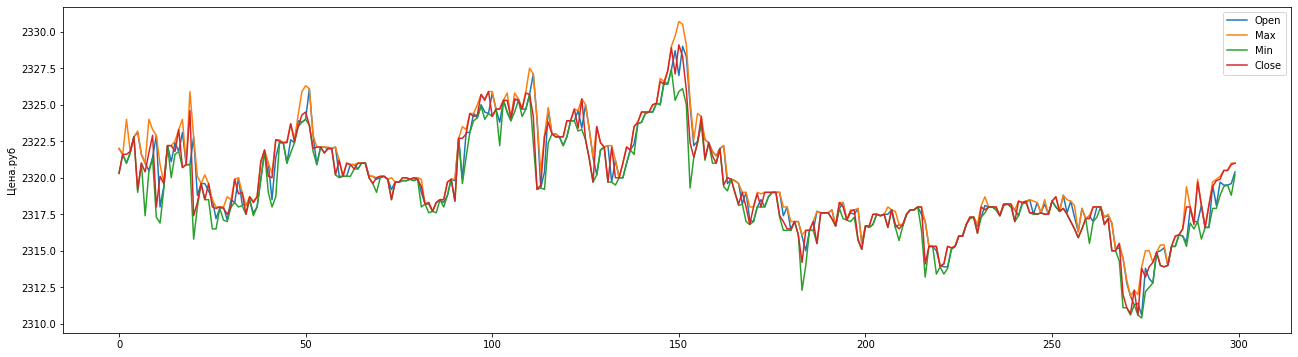

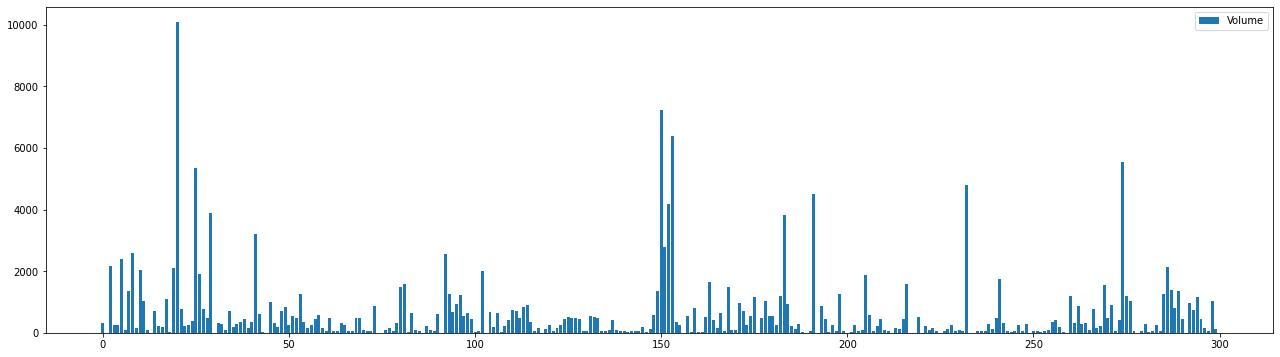

In [ ]:
start = 100
length = 300
columnNames = ['Open', 'Max', 'Min', 'Close', 'Volume']
plt.figure(figsize=(22,6))
for i in range(4):
  plt.plot(data[start:start+length,i], label=columnNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.figure(figsize=(22,6))
plt.bar(x=np.arange(length), height=data[start:start+length,4], label="Volume")
plt.legend()
plt.show()

#**Прогнозирование на 1 шаг вперед по столбцу Close - Dense сеть**

**3. Формирование обучающей и проверочной выборки**

In [ ]:
xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки
trainLen = data.shape[0]-valLen # Размер тренировочной выборки
x_train, x_test = data[:trainLen], data[trainLen+xLen:] #Делим данные на тренировочную и тестовую выборки 

#Нормирование данных
xScaler = MinMaxScaler()
xScaler.fit(x_train)
x_train = xScaler.transform(x_train)
x_test = xScaler.transform(x_test)
print(x_train.shape)
print(x_test.shape)

(451872, 5)
(29700, 5)


In [ ]:
#Формируем правильные и предсказанные ответы из колонки Close
y_train, y_test = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen:,3],(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(y_train)
y_train = yScaler.transform(y_train)
y_test = yScaler.transform(y_test)
print(y_train.shape)
print(y_test.shape)

(451872, 1)
(29700, 1)


In [ ]:
#Создаем генератор для обучения
train_gen = TimeseriesGenerator(x_train, y_train, length=xLen, stride=1, sampling_rate=1, batch_size=20)
test_gen = TimeseriesGenerator(x_test, y_test, length=xLen, stride=1, sampling_rate=1, batch_size=20)
print(train_gen[0][0].shape)  
print(train_gen[0][1].shape)     

(20, 300, 5)
(20, 1)


**4.Функции визуализации результатов**

In [ ]:
# Функция возвращает предсказанную и правильную Close цену без нормализации
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal)) # Предсказываем ответ сети по проверочной выборке и возвращаем исходны масштаб данных, до нормализации
  yValUnscaled = yScaler.inverse_transform(yVal) # Возвращаем правильный ответ без нормализации
  return (predVal, yValUnscaled)

# Функция визуализирует предсказанную и правильную Close цену без нормализации
def showPredict(start, step, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step], 
           label='Правильная Close')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

# Функция расчёта корреляции дух одномерных векторов
def correlate(a, b):
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

#Функция рисует корреляцию между предсказанной и правильной Close ценой без нормализации, а также между правильной Close ценой на поочередных шагах смещения к самому себе
def showCorr(corrSteps, predVal, yValUnscaled):
  corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i шагов обратно
  yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки
  for i in range(corrSteps):
    corr.append(correlate(yValUnscaled[:yLen-i], predVal[i:]))
  
  own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
  for i in range(corrSteps):
    own_corr.append(correlate(yValUnscaled[:yLen-i], yValUnscaled[i:]))
  
  plt.figure(figsize=(14,7))
  plt.plot(corr, label='Предсказание на 1 последующий шаг')
  plt.plot(own_corr, label='Эталон')
  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
val_gen = TimeseriesGenerator(x_test, y_test, length=xLen, sampling_rate=1, batch_size=len(x_test)) #размер batch будет равен длине нашей выборки
x_val = []
y_val = []
for i in val_gen:
  x_val.append(i[0])
  y_val.append(i[1])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val[0].shape)
print(y_val[0].shape)

(29400, 300, 5)
(29400, 1)


**5. Cоздаем и обучаем сеть**

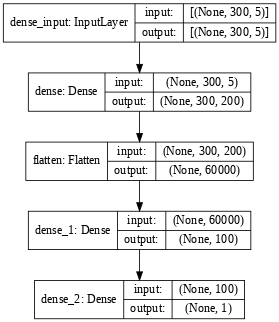

In [ ]:
modelD = Sequential()
modelD.add(Dense(200,input_shape = (xLen,5), activation="relu" ))
modelD.add(Flatten())
modelD.add(Dense(100, activation="relu"))
modelD.add(Dense(1, activation="linear"))

modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))
plot_model(modelD, dpi=60, show_shapes=True)

In [ ]:
history = modelD.fit(train_gen, epochs=30, verbose=1, validation_data = test_gen )

Epoch 1/30
22579/22579 [==============================] - 88s 4ms/step - loss: 6.2613e-04 - val_loss: 5.8039e-05
Epoch 2/30
22579/22579 [==============================] - 85s 4ms/step - loss: 6.1106e-05 - val_loss: 2.0525e-05
Epoch 3/30
22579/22579 [==============================] - 84s 4ms/step - loss: 3.6032e-05 - val_loss: 1.8352e-05
Epoch 4/30
22579/22579 [==============================] - 84s 4ms/step - loss: 2.5620e-05 - val_loss: 1.3844e-05
Epoch 5/30
22579/22579 [==============================] - 85s 4ms/step - loss: 2.0790e-05 - val_loss: 6.3114e-05
Epoch 6/30
22579/22579 [==============================] - 85s 4ms/step - loss: 2.0084e-05 - val_loss: 2.4607e-05
Epoch 7/30
22579/22579 [==============================] - 84s 4ms/step - loss: 1.7802e-05 - val_loss: 5.4669e-05
Epoch 8/30
22579/22579 [==============================] - 84s 4ms/step - loss: 1.6204e-05 - val_loss: 1.1082e-05
Epoch 9/30
22579/22579 [==============================] - 84s 4ms/step - loss: 1.5203e-05 - val_

**- Дообучаем с меньшим learning rate**

In [ ]:
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelD.fit(train_gen, epochs=30, verbose=1, validation_data = test_gen )

Epoch 1/30
22579/22579 [==============================] - 85s 4ms/step - loss: 3.4669e-06 - val_loss: 5.3267e-06
Epoch 2/30
22579/22579 [==============================] - 84s 4ms/step - loss: 3.3633e-06 - val_loss: 5.4980e-06
Epoch 3/30
22579/22579 [==============================] - 84s 4ms/step - loss: 3.3132e-06 - val_loss: 6.2527e-06
Epoch 4/30
22579/22579 [==============================] - 84s 4ms/step - loss: 3.2755e-06 - val_loss: 5.7644e-06
Epoch 5/30
22579/22579 [==============================] - 85s 4ms/step - loss: 3.2487e-06 - val_loss: 5.8542e-06
Epoch 6/30
22579/22579 [==============================] - 85s 4ms/step - loss: 3.2062e-06 - val_loss: 5.0697e-06
Epoch 7/30
22579/22579 [==============================] - 84s 4ms/step - loss: 3.1604e-06 - val_loss: 5.0662e-06
Epoch 8/30
22579/22579 [==============================] - 84s 4ms/step - loss: 3.1661e-06 - val_loss: 5.3522e-06
Epoch 9/30
22579/22579 [==============================] - 85s 4ms/step - loss: 3.1151e-06 - val_

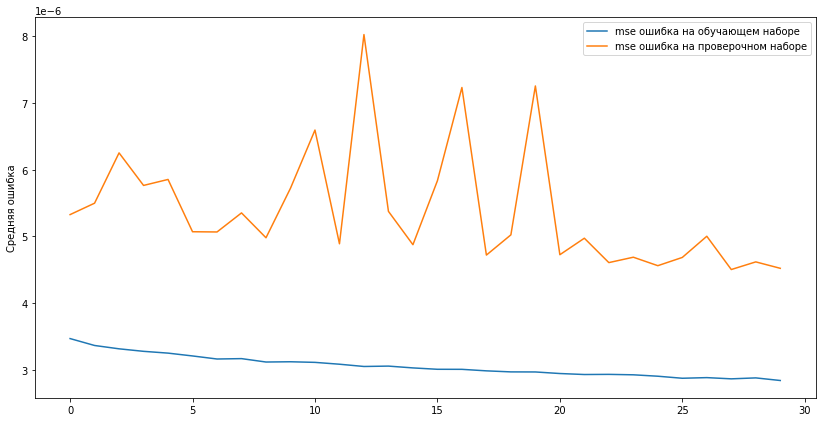

In [ ]:
#Выводим графики ошибок
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='mse ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='mse ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

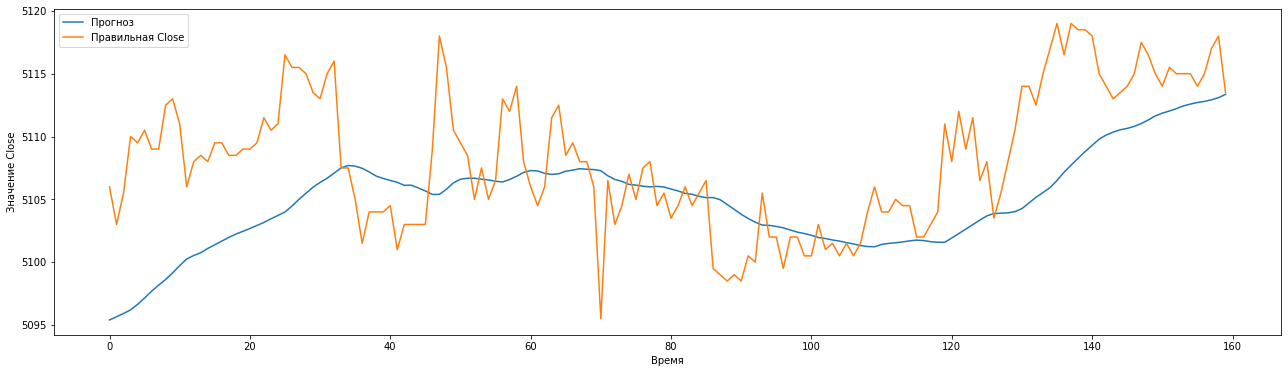

In [ ]:
#Прогнозируем предсказанную и правильную Close цену без нормализации
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, x_val[0], y_val[0], yScaler) #Прогнозируем данные
#Отображаем предсказанную и правильную Close цену без нормализации
showPredict(0, 160, predVal, yValUnscaled)

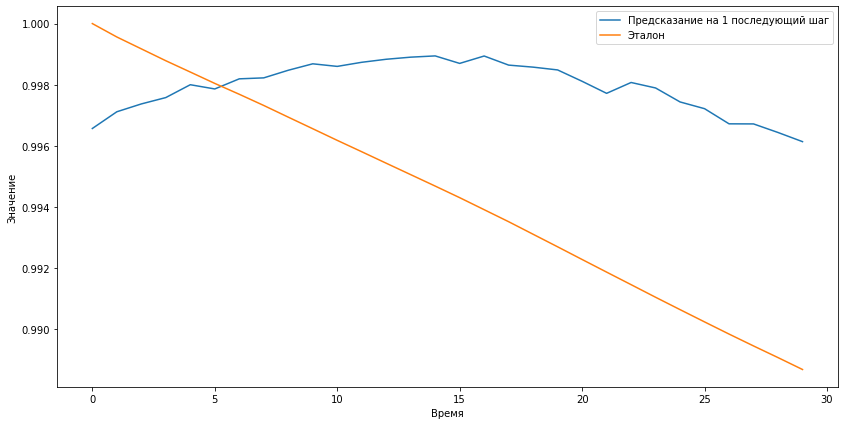

In [ ]:
#Отображаем корреляцию
#Проверяем корреляцию на глубину 30 шагов
showCorr(30, predVal, yValUnscaled)

#**Прогнозирование на 10 шагов вперед по столбцу Close - Dense сеть**

**3. Формирование обучающей и проверочной выборки**

In [ ]:
xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки
predSteps=9                     #прогнозирование на данной минуте + на последующих 9 минутах, в итоге будет 10 поочередных прогнозов
trainLen = data.shape[0]-valLen # Размер тренировочной выборки
x_train10, x_test10 = data[:trainLen], data[trainLen+xLen:-predSteps] #Делим данные на тренировочную и тестовую выборки 

#Нормирование данных
xScaler = MinMaxScaler()
xScaler.fit(x_train10)
x_train10 = xScaler.transform(x_train10)
x_test10 = xScaler.transform(x_test10)
print(x_train10.shape)
print(x_test10.shape)

(451872, 5)
(29691, 5)


In [ ]:
#Формируем правильные и предсказанные ответы из колонки Close
y_train10, y_test10 = data[:trainLen+predSteps,3], data[trainLen+xLen:,3]
y_train10=[[y_train10[x], y_train10[x+1], y_train10[x+2], y_train10[x+3], y_train10[x+4], y_train10[x+5], y_train10[x+6], y_train10[x+7], y_train10[x+8], y_train10[x+9]] for x in range(len(y_train10)-predSteps)]
y_test10=[[y_test10[x], y_test10[x+1], y_test10[x+2], y_test10[x+3], y_test10[x+4], y_test10[x+5], y_test10[x+6], y_test10[x+7], y_test10[x+8], y_test10[x+9]] for x in range(len(y_test10)-predSteps)]
yScaler = MinMaxScaler()
yScaler.fit(y_train10)
y_train10 = yScaler.transform(y_train10)
y_test10 = yScaler.transform(y_test10)
print(y_train10.shape)
print(y_test10.shape)

(451872, 10)
(29691, 10)


In [ ]:
#Создаем генератор для обучения
train_gen10 = TimeseriesGenerator(x_train10, y_train10, length=xLen, stride=1, sampling_rate=1, batch_size=20)
test_gen10 = TimeseriesGenerator(x_test10, y_test10, length=xLen, stride=1, sampling_rate=1, batch_size=20)
print(train_gen10[0][0].shape)  
print(train_gen10[0][1].shape) 

(20, 300, 5)
(20, 10)


**4.Функции визуализации результатов**

In [ ]:
# Функция визуализирует предсказанную и правильную Close цену без нормализации
def showPredict10(start, step, channels, predVal, yValUnscaled):
  for ch in range(channels):
    plt.figure(figsize=(22,6))
    plt.plot(predVal[start:start+step, ch],
           label='Прогноз на ' + str(ch+1) + ' шаг')
    plt.plot(yValUnscaled[start:start+step, ch], 
           label='Правильная цена Close на ' + str(ch+1) + ' шаг')
    plt.xlabel('Время')
    plt.ylabel('Значение Close')
    plt.legend()
    plt.show()

#Функция рисует корреляцию между предсказанной и правильной Close ценой без нормализации, а также между правильной Close ценой на поочередных шагах смещения к самому себе
def showCorr10(channels, corrSteps, predVal, yValUnscaled):
  for ch in range(channels):
    corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:,ch]))
  
    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:,ch]))
  
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон на ' + str(ch+1) + ' шаг')
    plt.xlabel('Шаг смещения')
    plt.ylabel('Значение корреляции')
    plt.legend()
    plt.show()

#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
val_gen10 = TimeseriesGenerator(x_test10, y_test10, length=xLen, sampling_rate=1, batch_size=len(x_test10)) #размер batch будет равен длине нашей выборки
x_val10 = []
y_val10 = []
for i in val_gen10:
  x_val10.append(i[0])
  y_val10.append(i[1])

x_val10 = np.array(x_val10)
y_val10 = np.array(y_val10)
print(x_val10[0].shape)
print(y_val10[0].shape)

(29391, 300, 5)
(29391, 10)


**5. Cоздаем и обучаем сеть**

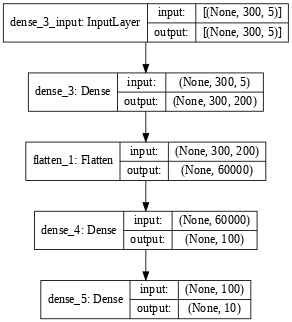

In [ ]:
modelD10 = Sequential()
modelD10.add(Dense(200,input_shape = (xLen,5), activation="relu" ))
modelD10.add(Flatten())
modelD10.add(Dense(100, activation="relu"))
modelD10.add(Dense(10, activation="linear"))

modelD10.compile(loss="mse", optimizer=Adam(lr=1e-4))
plot_model(modelD10, dpi=60, show_shapes=True)

In [ ]:
history = modelD10.fit(train_gen10, epochs=30, verbose=1, validation_data = test_gen10 )

Epoch 1/30
22579/22579 [==============================] - 86s 4ms/step - loss: 3.8637e-04 - val_loss: 5.0311e-05
Epoch 2/30
22579/22579 [==============================] - 86s 4ms/step - loss: 6.1696e-05 - val_loss: 2.5188e-04
Epoch 3/30
22579/22579 [==============================] - 86s 4ms/step - loss: 4.1168e-05 - val_loss: 3.8438e-05
Epoch 4/30
22579/22579 [==============================] - 87s 4ms/step - loss: 3.0346e-05 - val_loss: 2.7446e-05
Epoch 5/30
22579/22579 [==============================] - 86s 4ms/step - loss: 2.4327e-05 - val_loss: 2.1632e-05
Epoch 6/30
22579/22579 [==============================] - 87s 4ms/step - loss: 2.1739e-05 - val_loss: 1.8474e-05
Epoch 7/30
22579/22579 [==============================] - 86s 4ms/step - loss: 2.0430e-05 - val_loss: 2.6009e-05
Epoch 8/30
22579/22579 [==============================] - 87s 4ms/step - loss: 1.9024e-05 - val_loss: 1.3045e-05
Epoch 9/30
22579/22579 [==============================] - 86s 4ms/step - loss: 1.7360e-05 - val_

**- Дообучаем с меньшим learning rate**

In [ ]:
modelD10.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelD10.fit(train_gen10, epochs=30, verbose=1, validation_data = test_gen10 )

Epoch 1/30
22579/22579 [==============================] - 86s 4ms/step - loss: 5.5154e-06 - val_loss: 8.8792e-06
Epoch 2/30
22579/22579 [==============================] - 86s 4ms/step - loss: 5.3964e-06 - val_loss: 8.1062e-06
Epoch 3/30
22579/22579 [==============================] - 86s 4ms/step - loss: 5.3852e-06 - val_loss: 8.8383e-06
Epoch 4/30
22579/22579 [==============================] - 86s 4ms/step - loss: 5.3631e-06 - val_loss: 8.5177e-06
Epoch 5/30
22579/22579 [==============================] - 86s 4ms/step - loss: 5.3258e-06 - val_loss: 9.3268e-06
Epoch 6/30
22579/22579 [==============================] - 86s 4ms/step - loss: 5.2756e-06 - val_loss: 7.8911e-06
Epoch 7/30
22579/22579 [==============================] - 86s 4ms/step - loss: 5.2519e-06 - val_loss: 9.2771e-06
Epoch 8/30
22579/22579 [==============================] - 86s 4ms/step - loss: 5.2230e-06 - val_loss: 8.4075e-06
Epoch 9/30
22579/22579 [==============================] - 86s 4ms/step - loss: 5.1971e-06 - val_

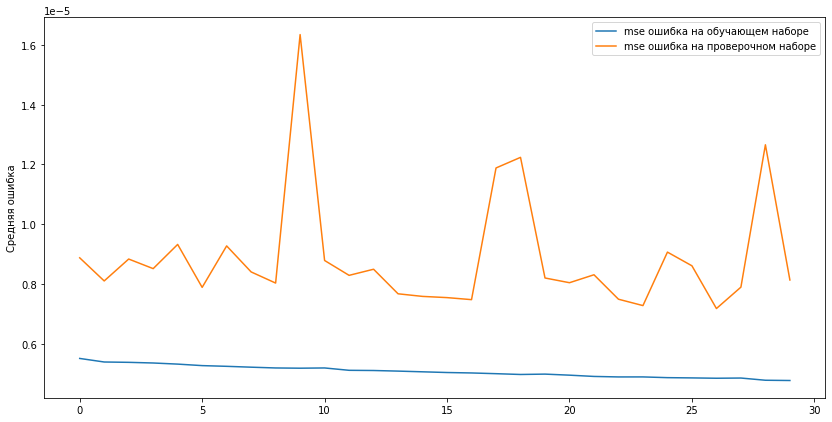

In [ ]:
#Выводим графики ошибок
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='mse ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='mse ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

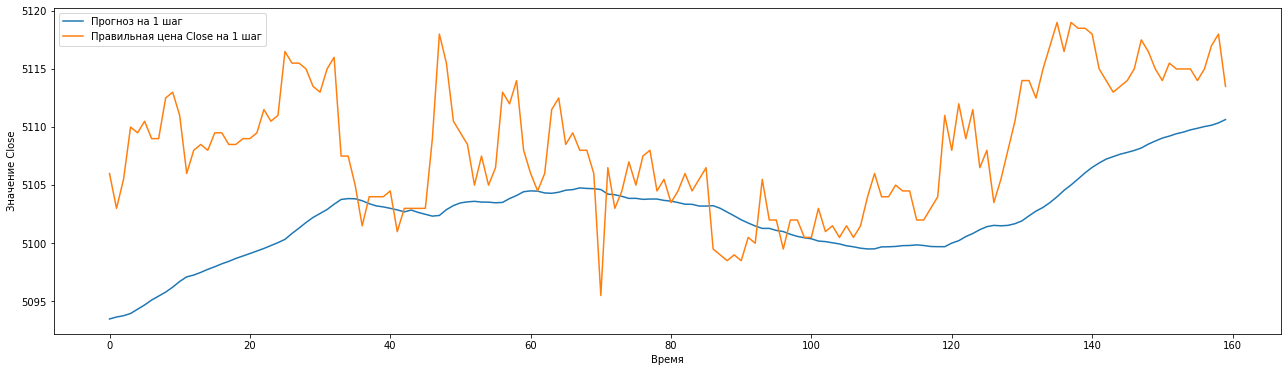

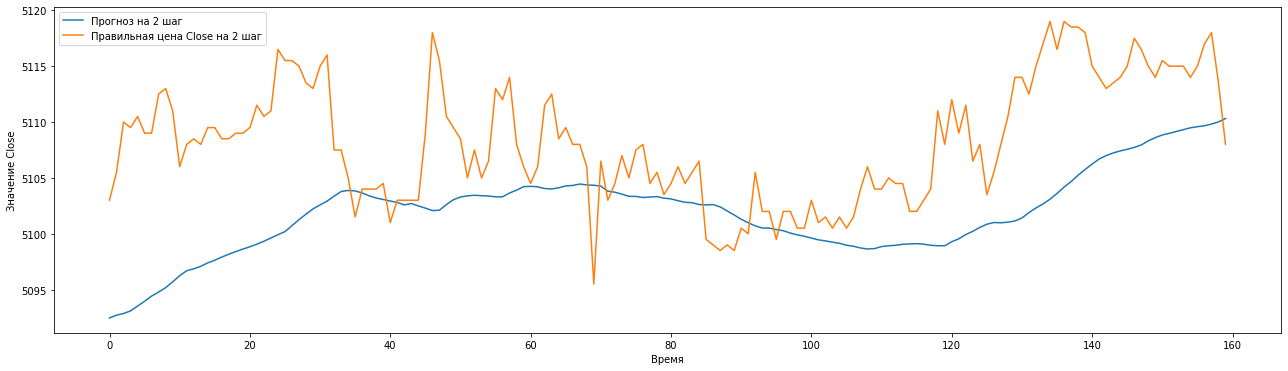

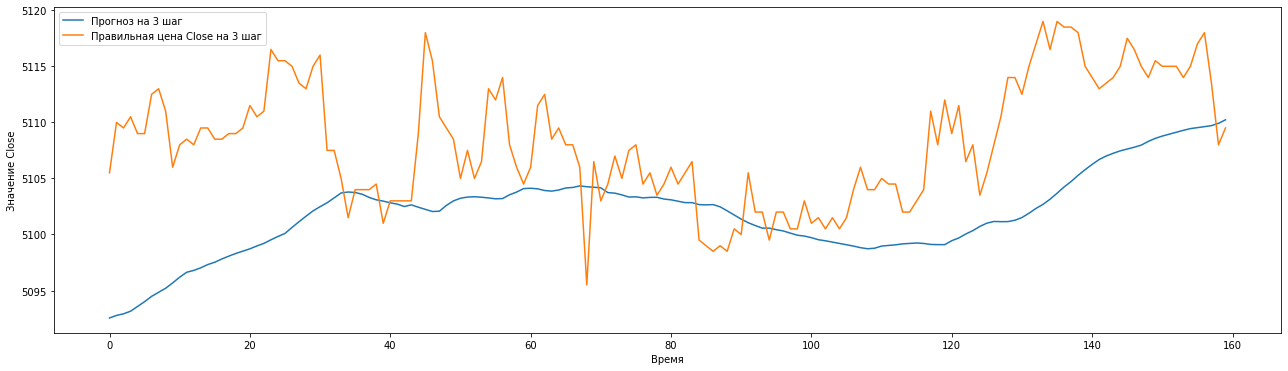

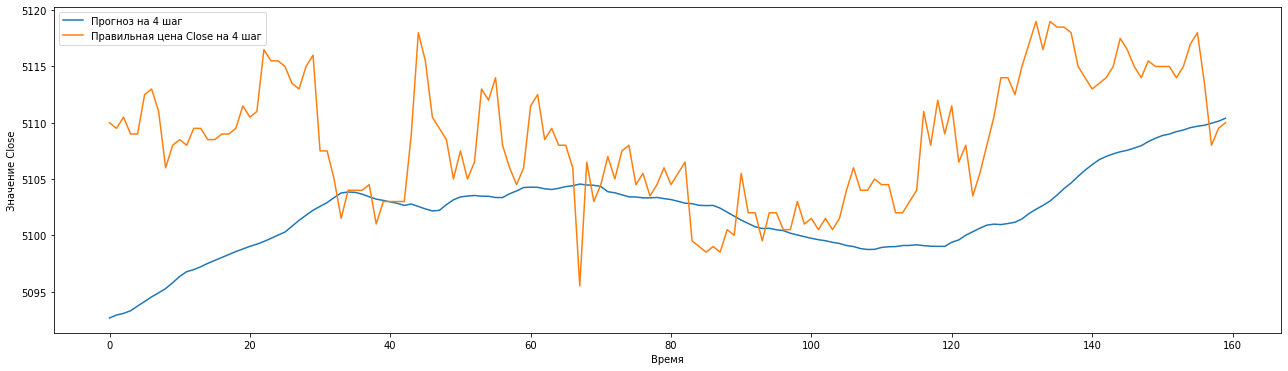

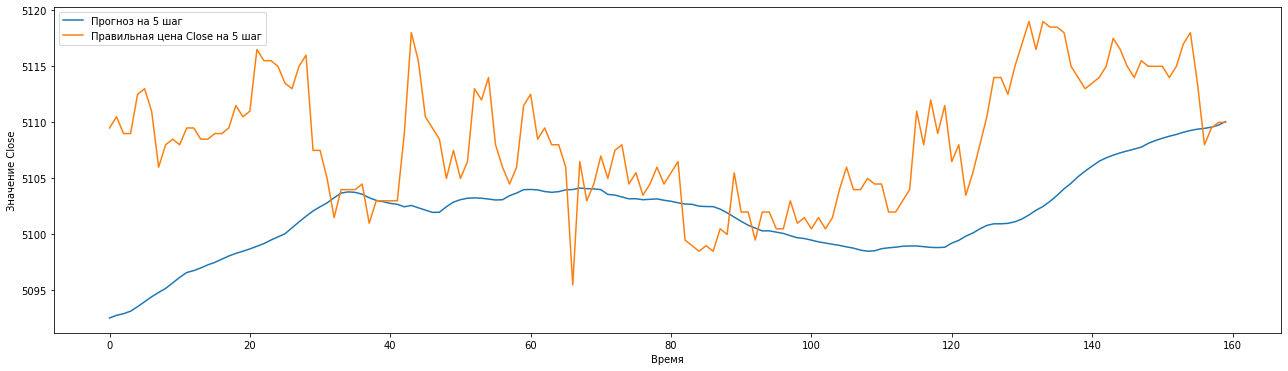

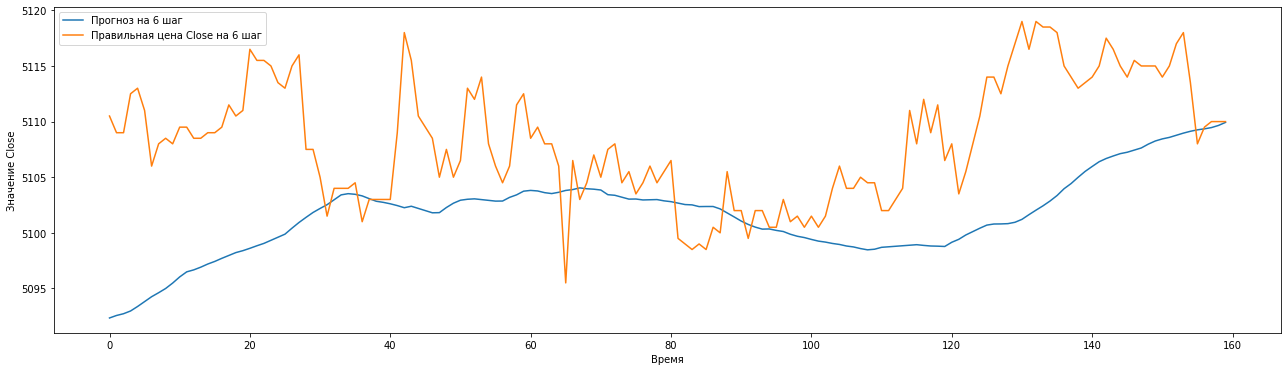

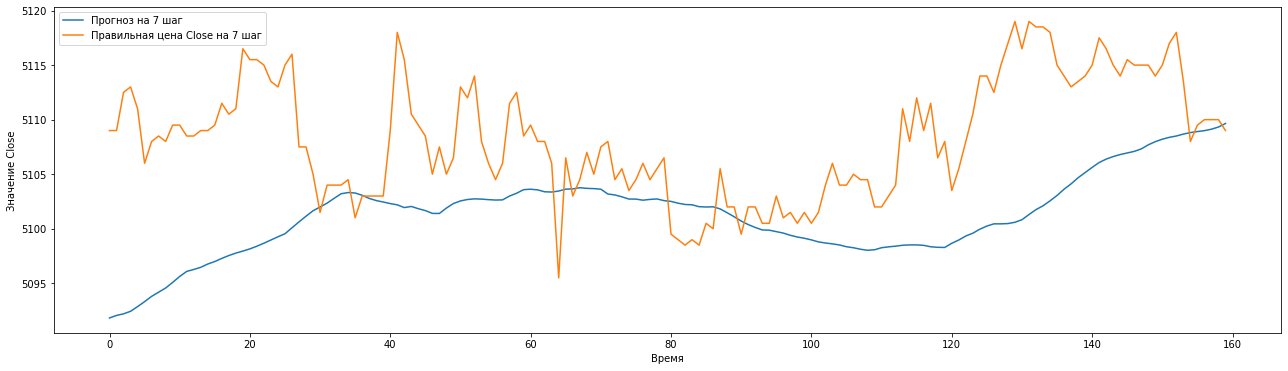

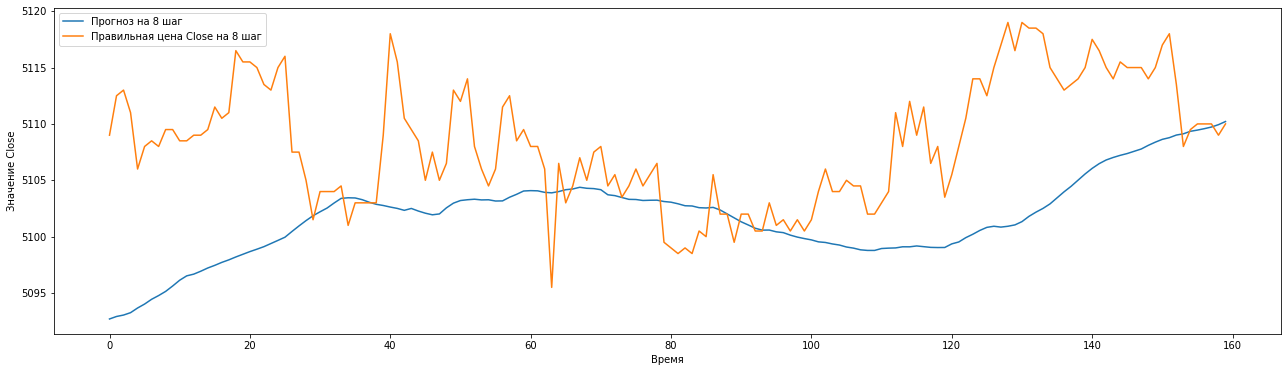

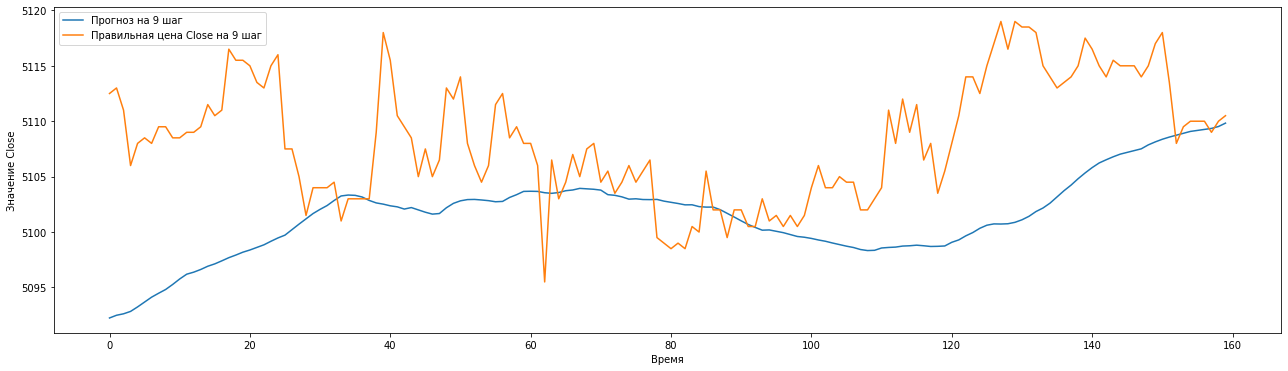

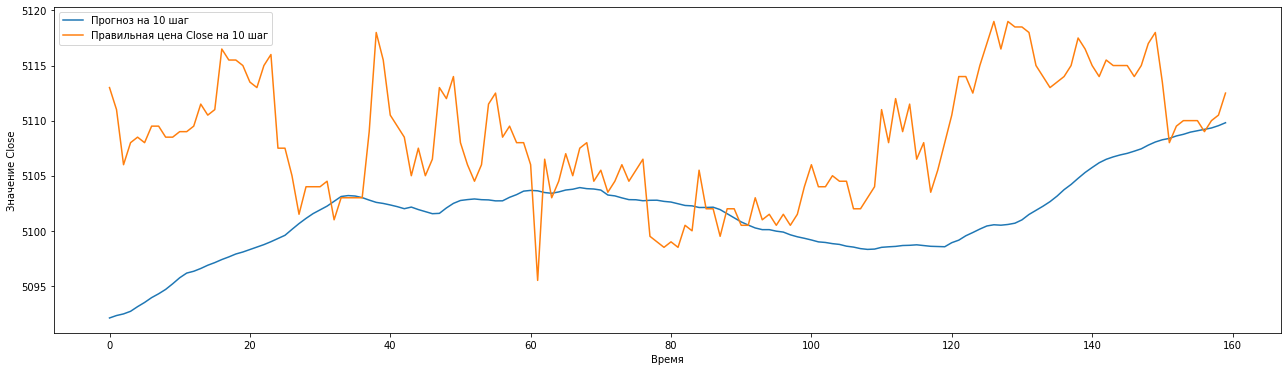

In [ ]:
#Прогнозируем предсказанные и правильные Close цены на 10 шагов вперед без нормализации
currModel = modelD10 #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, x_val10[0], y_val10[0], yScaler) #Прогнозируем данные
#Отображаем предсказанные и правильные Close цены на 10 шагов вперед без нормализации
showPredict10(0, 160, 10, predVal, yValUnscaled)

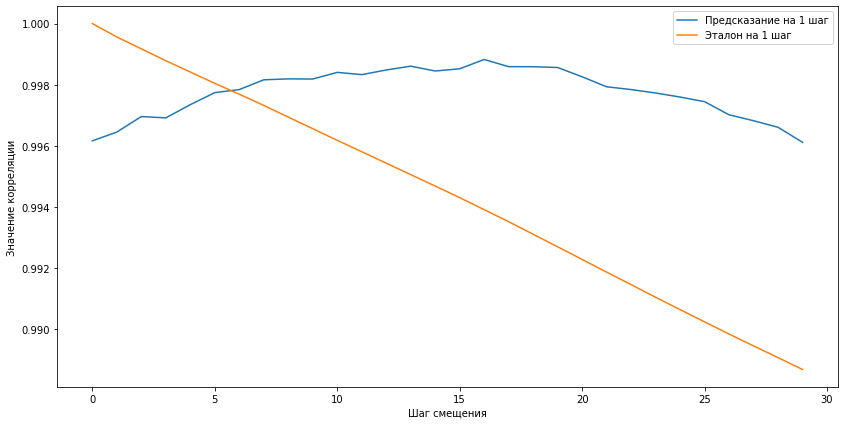

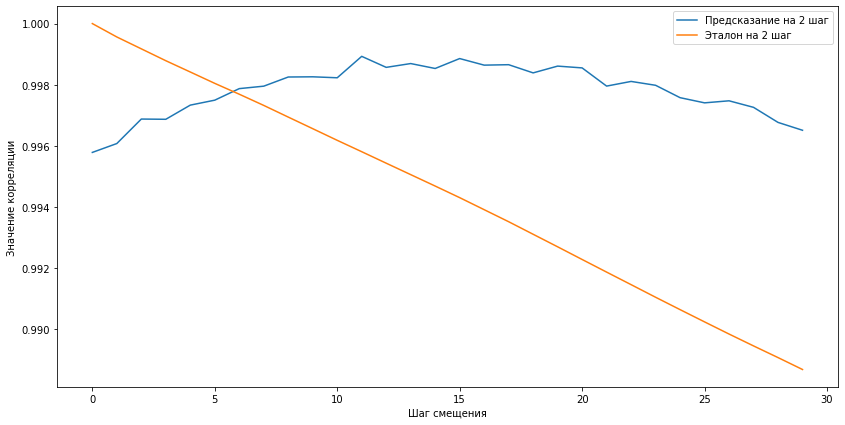

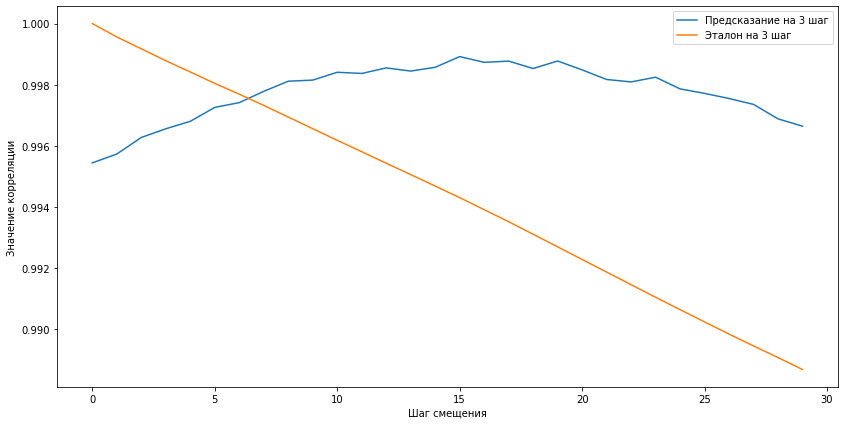

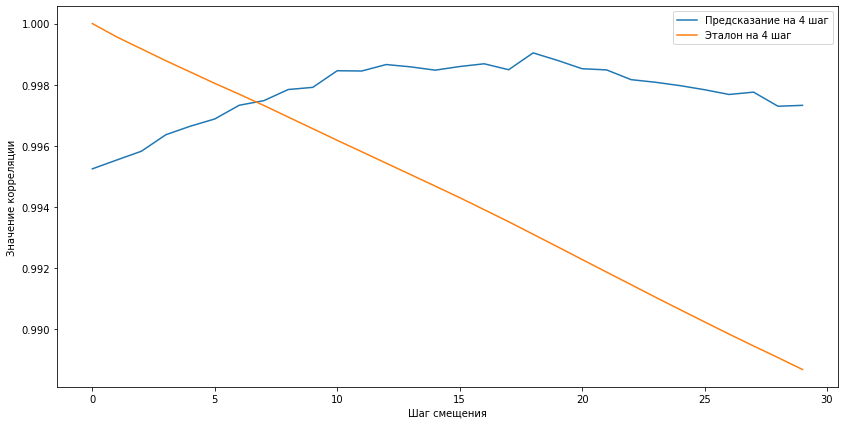

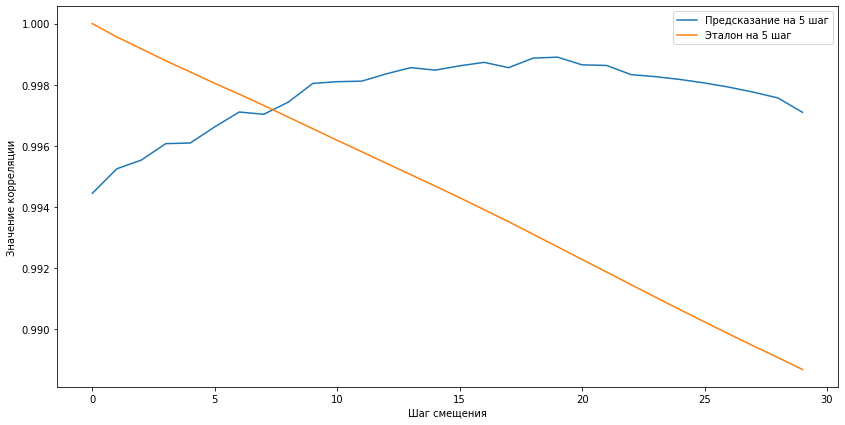

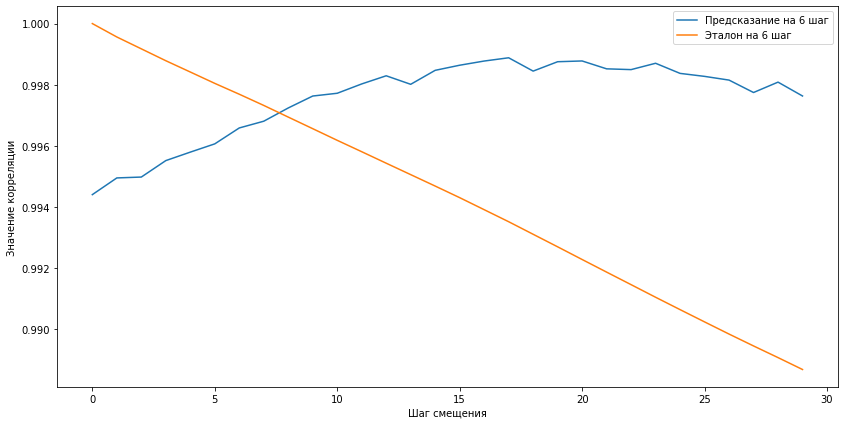

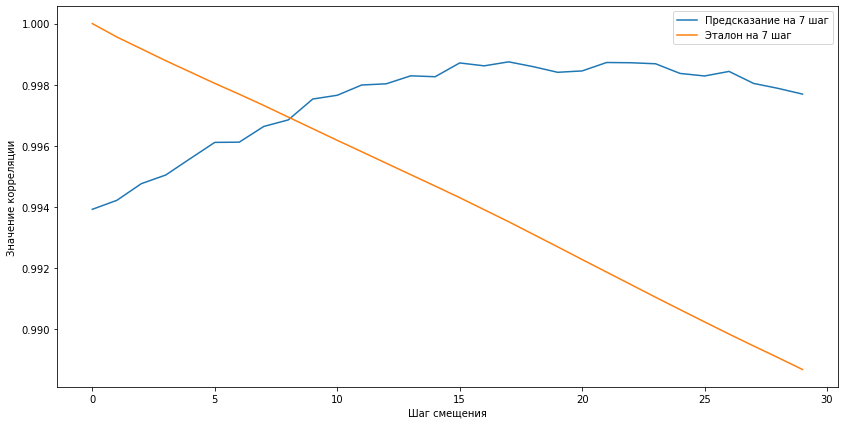

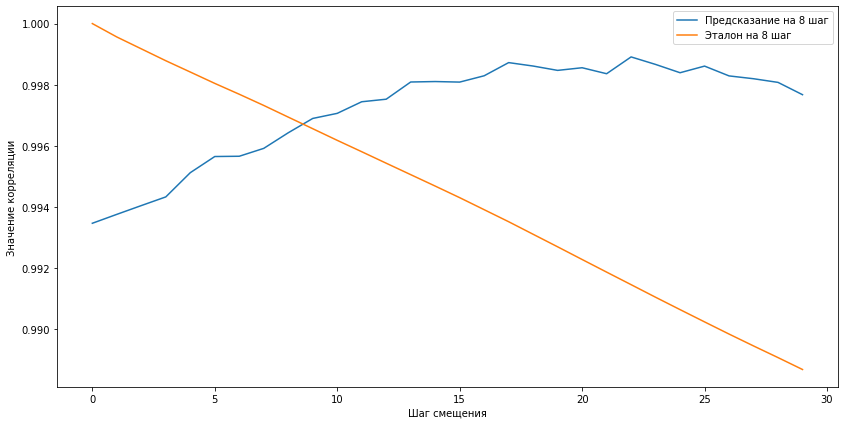

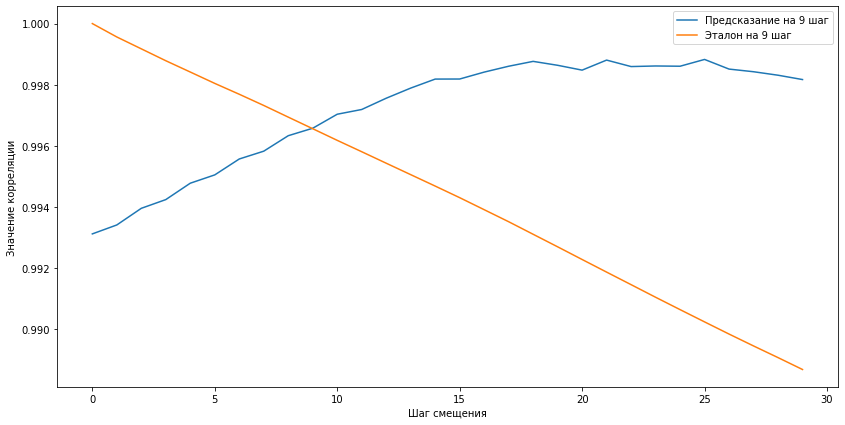

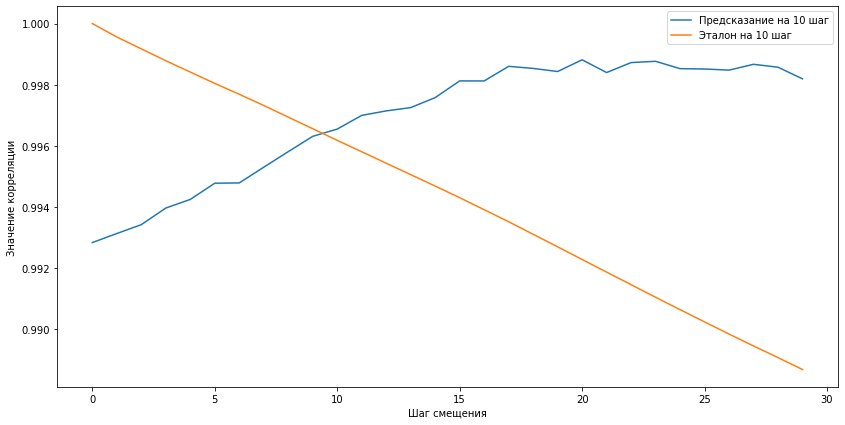

In [ ]:
#Проверяем и Отображаем корреляцию на глубину 30 шагов на каждом канале
showCorr10(10, 30, predVal, yValUnscaled)

#**Прогнозирование на 1 шаг вперед по столбцу Close - LSTM сеть**

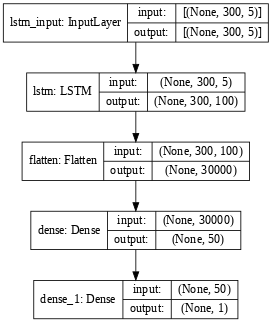

In [ ]:
modelL = Sequential()
modelL.add(LSTM(100, input_shape = (xLen, 5), return_sequences=True))
modelL.add(Flatten())
modelL.add(Dense(50, activation="relu"))
modelL.add(Dense(1, activation="linear"))

modelL.compile(loss="mse", optimizer='rmsprop')
plot_model(modelL, dpi=60, show_shapes=True)

In [ ]:
history = modelL.fit(train_gen, epochs=30, verbose=1, validation_data = test_gen )

Epoch 1/30
22579/22579 [==============================] - 308s 13ms/step - loss: 0.0017 - val_loss: 3.4757e-05
Epoch 2/30
22579/22579 [==============================] - 290s 13ms/step - loss: 1.6823e-04 - val_loss: 5.9354e-05
Epoch 3/30
22579/22579 [==============================] - 288s 13ms/step - loss: 1.2152e-04 - val_loss: 1.1920e-04
Epoch 4/30
22579/22579 [==============================] - 294s 13ms/step - loss: 9.8571e-05 - val_loss: 5.8047e-04
Epoch 5/30
22579/22579 [==============================] - 289s 13ms/step - loss: 8.3881e-05 - val_loss: 3.6231e-04
Epoch 6/30
22579/22579 [==============================] - 287s 13ms/step - loss: 7.1347e-05 - val_loss: 2.6587e-05
Epoch 7/30
22579/22579 [==============================] - 288s 13ms/step - loss: 6.4254e-05 - val_loss: 1.7207e-05
Epoch 8/30
22579/22579 [==============================] - 286s 13ms/step - loss: 5.6784e-05 - val_loss: 3.7097e-05
Epoch 9/30
22579/22579 [==============================] - 285s 13ms/step - loss: 5.3

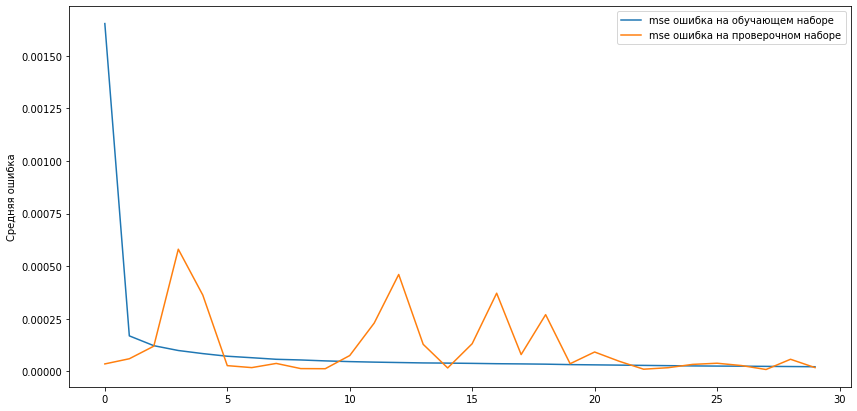

In [ ]:
#Выводим графики ошибок
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='mse ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='mse ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

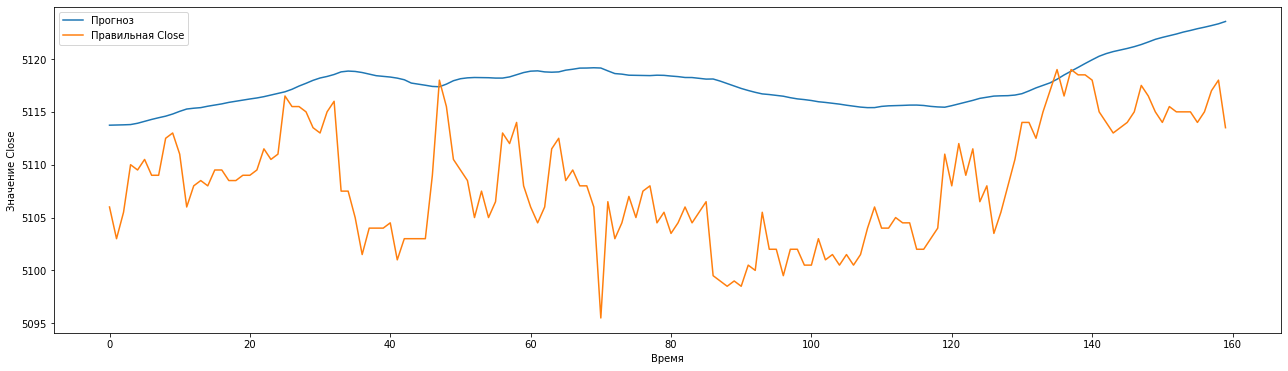

In [ ]:
#Прогнозируем предсказанную и правильную Close цену без нормализации
currModel = modelL #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, x_val[0], y_val[0], yScaler) #Прогнозируем данные
#Отображаем предсказанную и правильную Close цену без нормализации
showPredict(0,160, predVal, yValUnscaled)

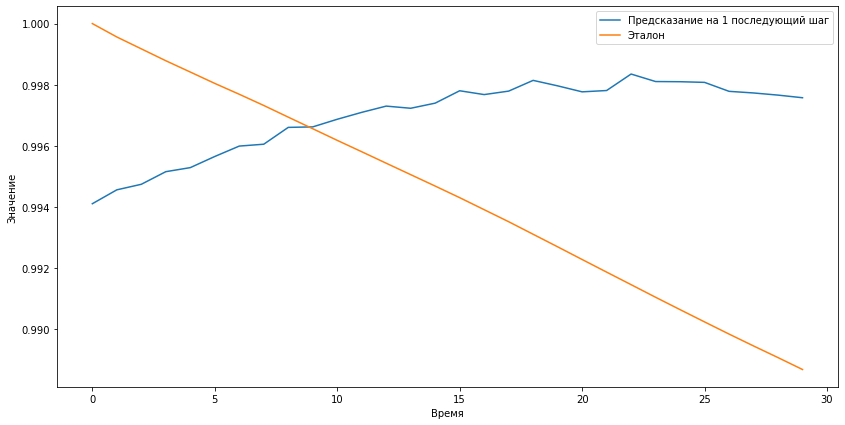

In [ ]:
#Отображаем корреляцию
#Проверяем корреляцию на глубину 30 шагов
showCorr(30, predVal, yValUnscaled)

#**Прогнозирование на 10 шагов вперед по столбцу Close - LMST сеть**

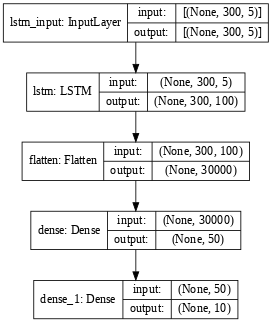

In [ ]:
modelL10 = Sequential()
modelL10.add(LSTM(100, input_shape = (xLen, 5), return_sequences=True))
modelL10.add(Flatten())
modelL10.add(Dense(50, activation="relu"))
modelL10.add(Dense(10, activation="linear"))

modelL10.compile(loss="mse", optimizer='rmsprop')
plot_model(modelL10, dpi=60, show_shapes=True)

In [ ]:
history = modelL10.fit(train_gen10, epochs=30, verbose=1, validation_data = test_gen10 )

Epoch 1/30
22579/22579 [==============================] - 290s 13ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 2/30
22579/22579 [==============================] - 281s 12ms/step - loss: 1.7725e-04 - val_loss: 7.9956e-04
Epoch 3/30
22579/22579 [==============================] - 280s 12ms/step - loss: 1.1448e-04 - val_loss: 0.0012
Epoch 4/30
22579/22579 [==============================] - 279s 12ms/step - loss: 9.1575e-05 - val_loss: 3.9497e-04
Epoch 5/30
22579/22579 [==============================] - 278s 12ms/step - loss: 7.3929e-05 - val_loss: 1.9028e-05
Epoch 6/30
22579/22579 [==============================] - 280s 12ms/step - loss: 6.5063e-05 - val_loss: 4.1369e-05
Epoch 7/30
22579/22579 [==============================] - 286s 13ms/step - loss: 5.9254e-05 - val_loss: 2.5646e-04
Epoch 8/30
22579/22579 [==============================] - 287s 13ms/step - loss: 5.6317e-05 - val_loss: 5.7588e-04
Epoch 9/30
22579/22579 [==============================] - 279s 12ms/step - loss: 5.3275e-05 

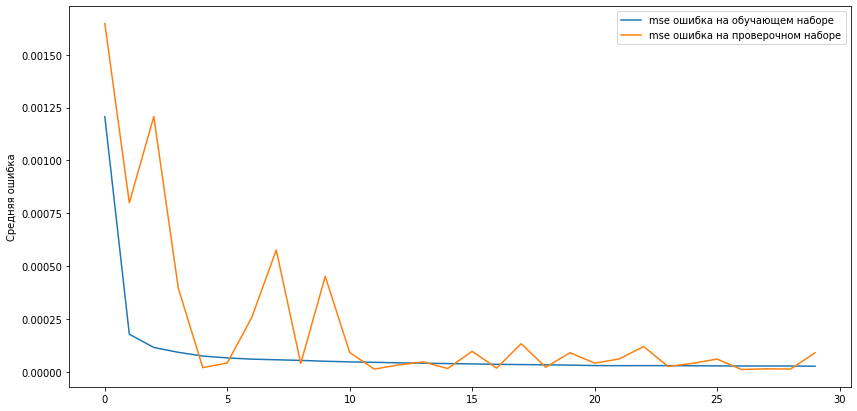

In [ ]:
#Выводим графики ошибок
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='mse ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='mse ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

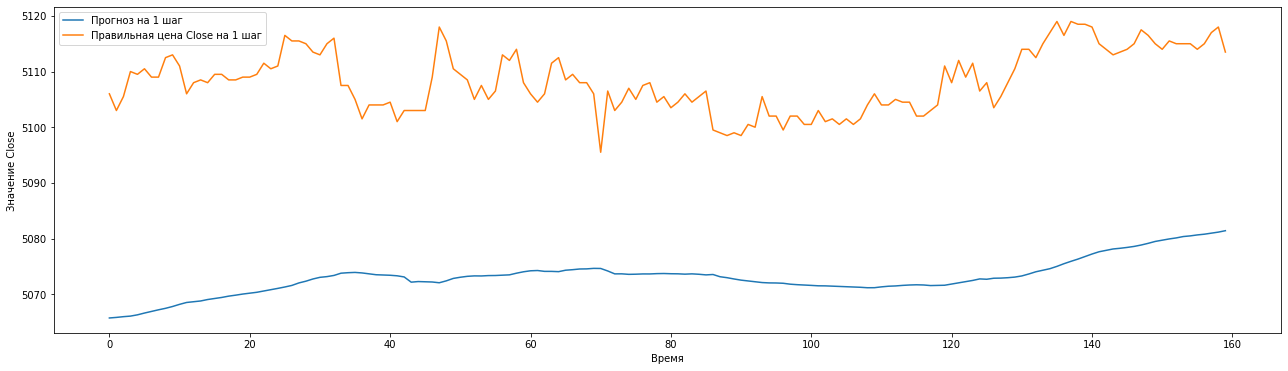

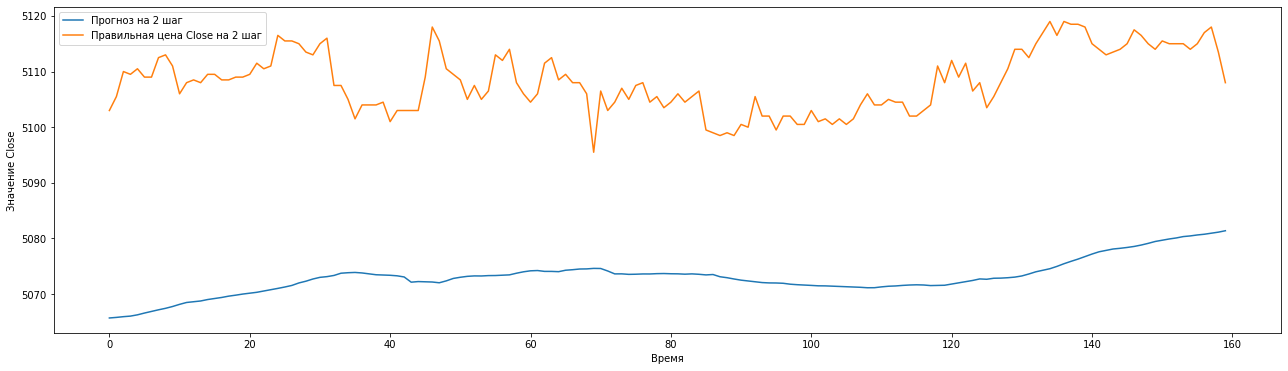

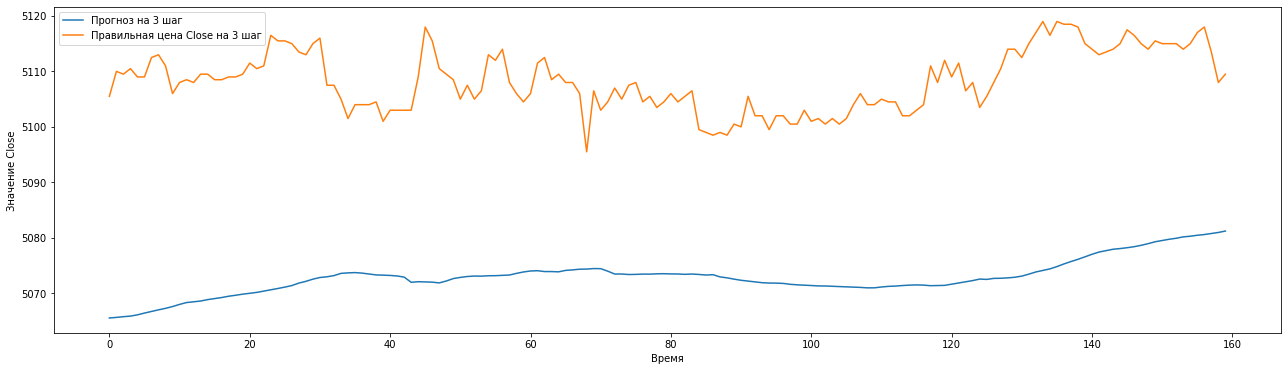

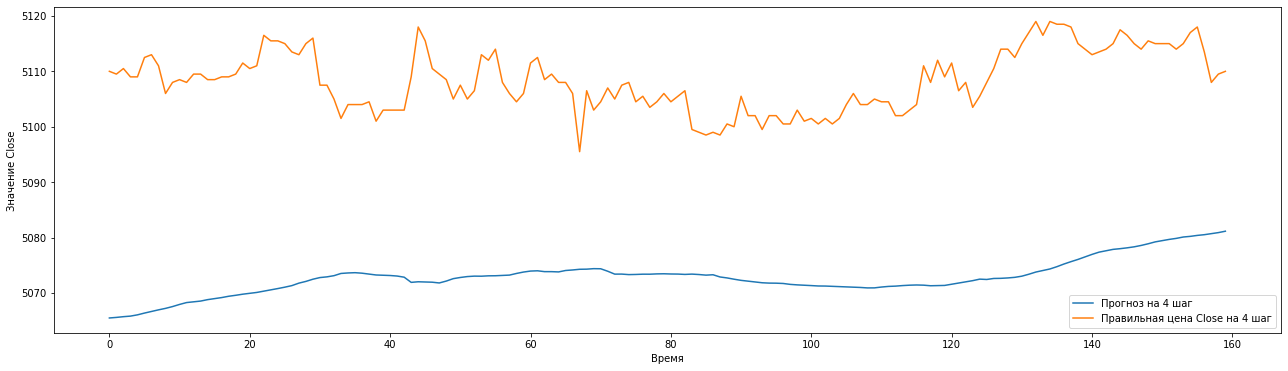

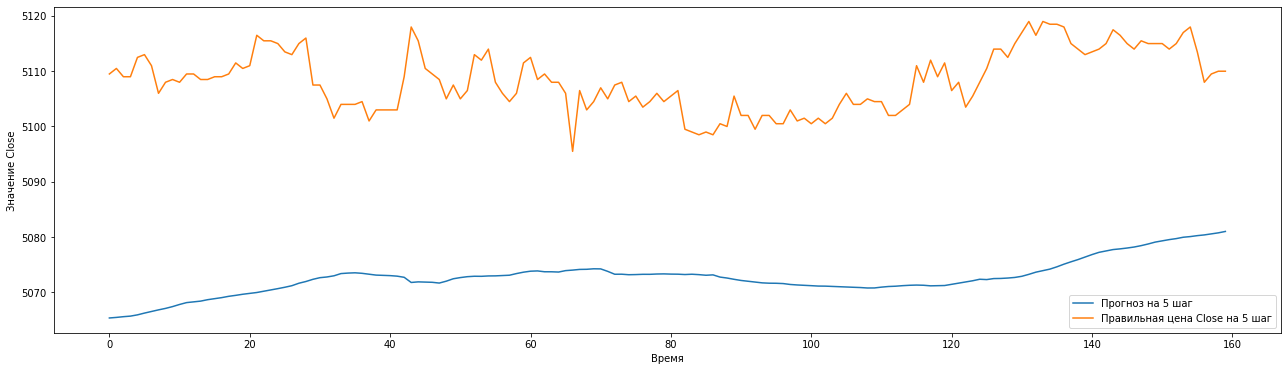

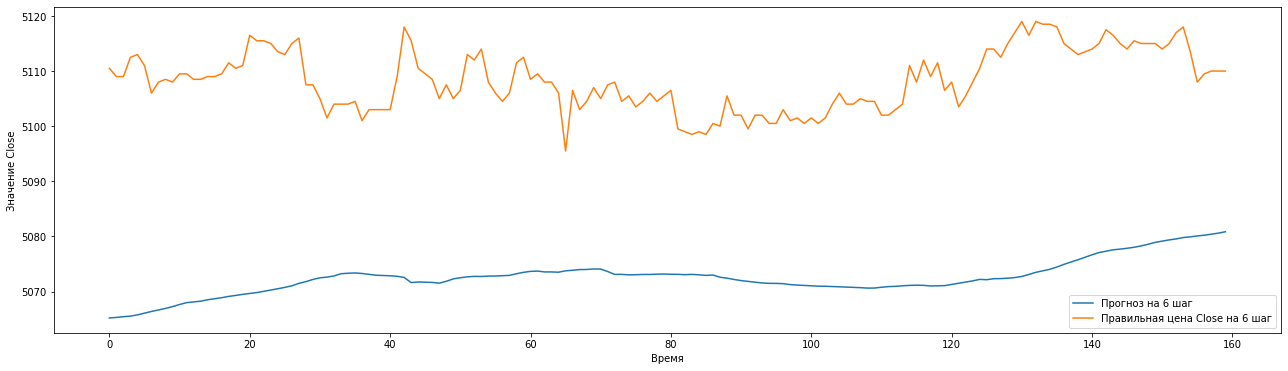

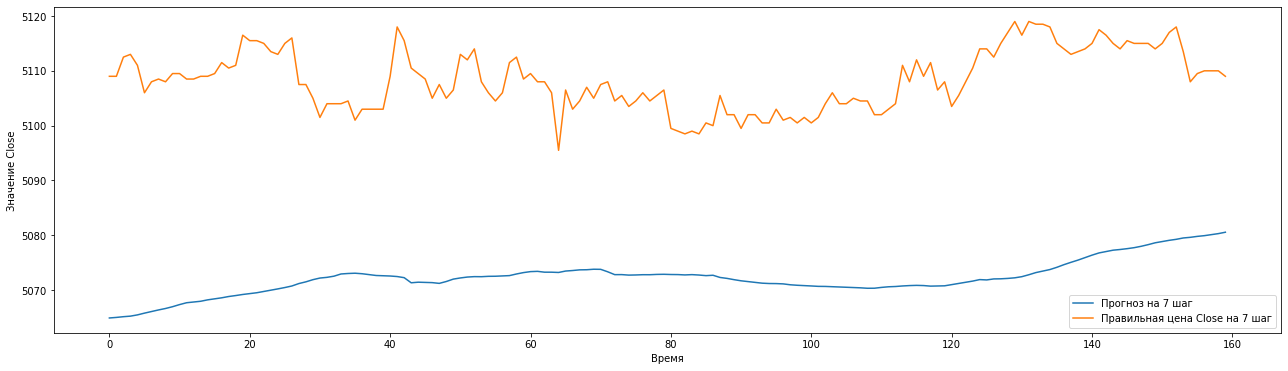

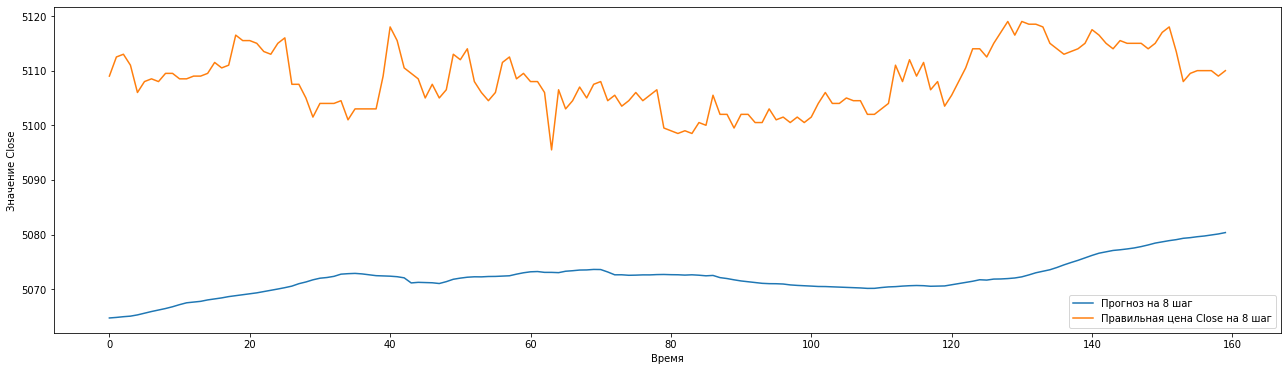

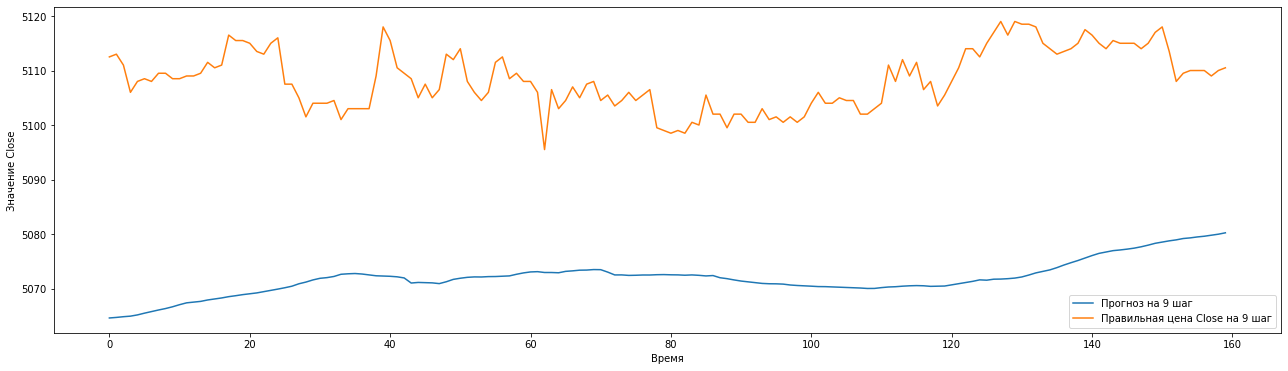

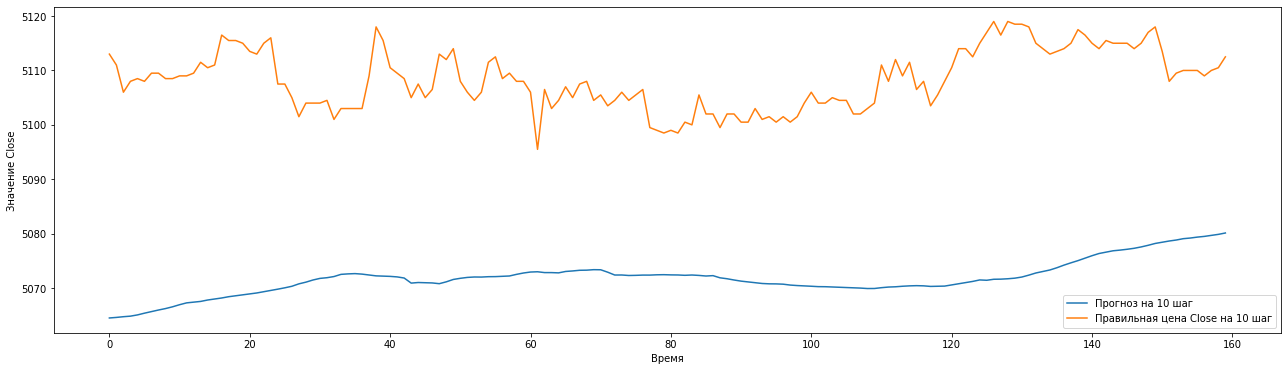

In [ ]:
#Прогнозируем предсказанные и правильные Close цены на 10 шагов вперед без нормализации
currModel = modelL10 #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, x_val10[0], y_val10[0], yScaler) #Прогнозируем данные
#Отображаем предсказанные и правильные Close цены на 10 шагов вперед без нормализации
showPredict10(0, 160, 10, predVal, yValUnscaled)

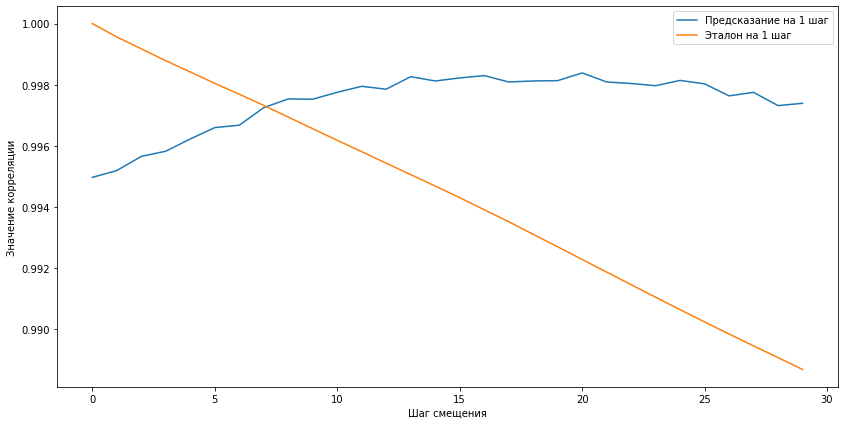

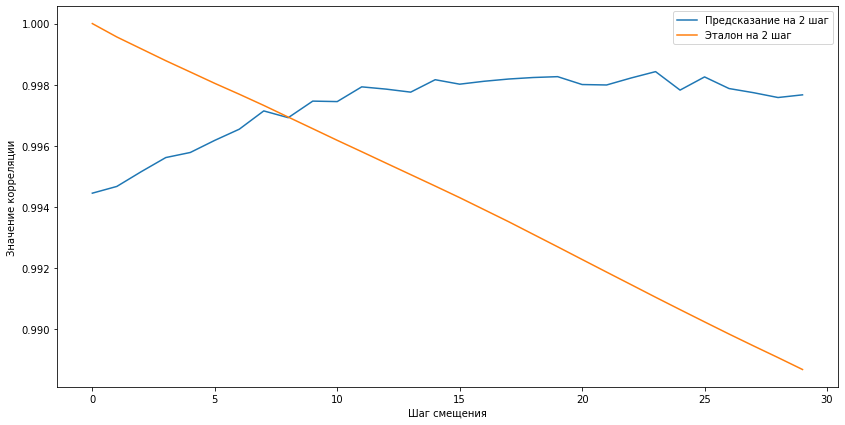

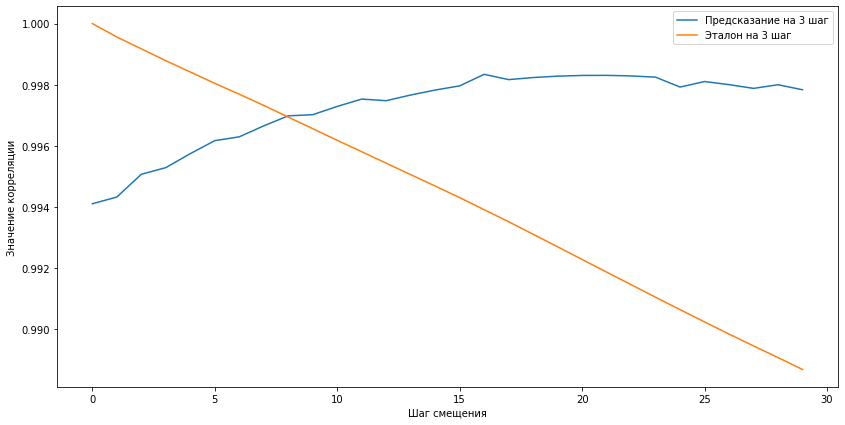

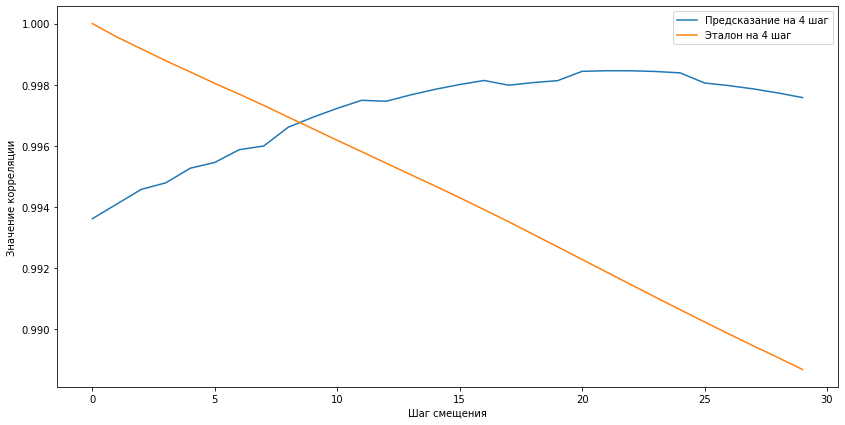

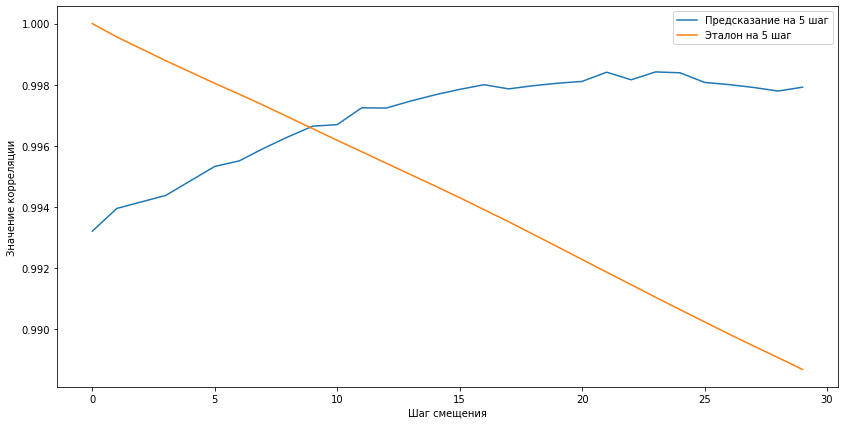

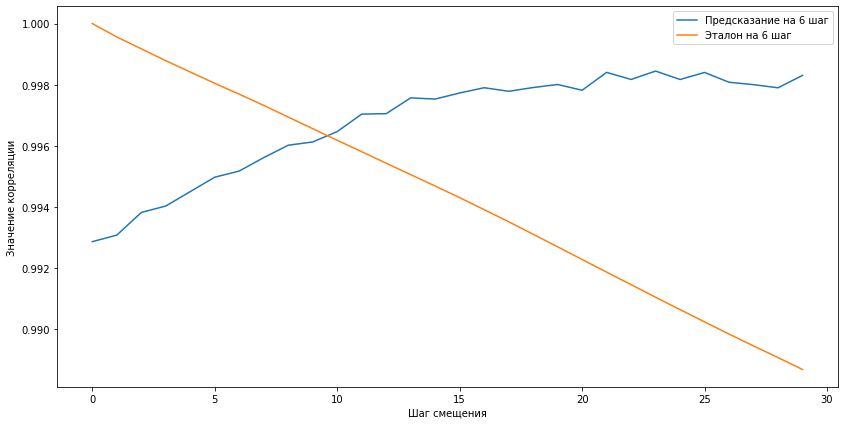

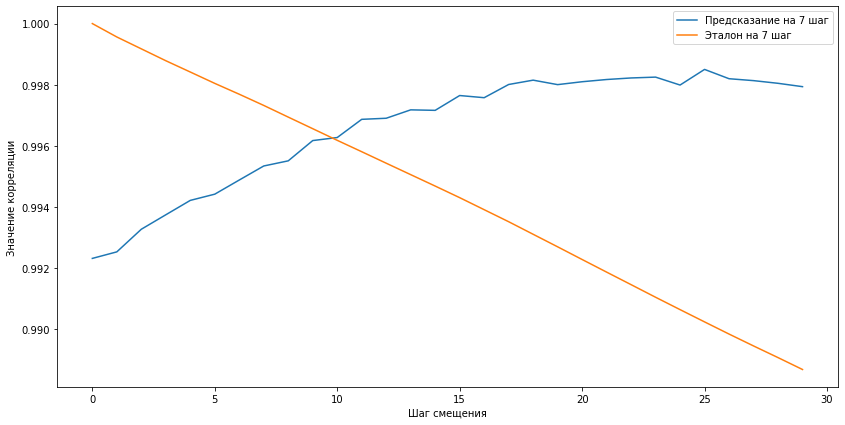

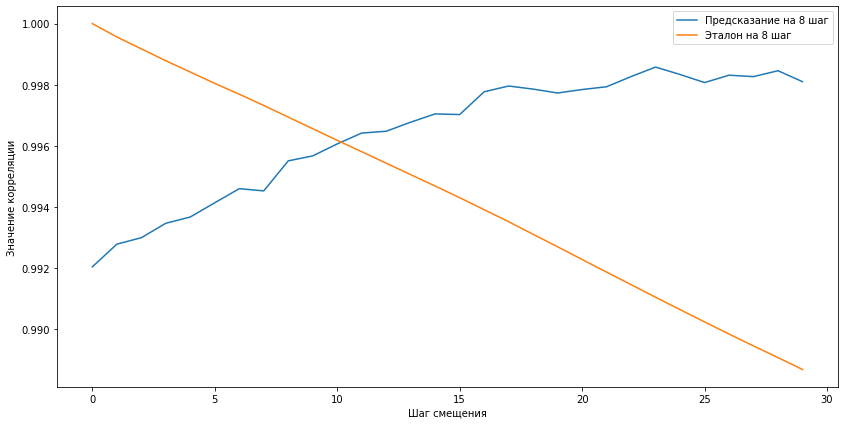

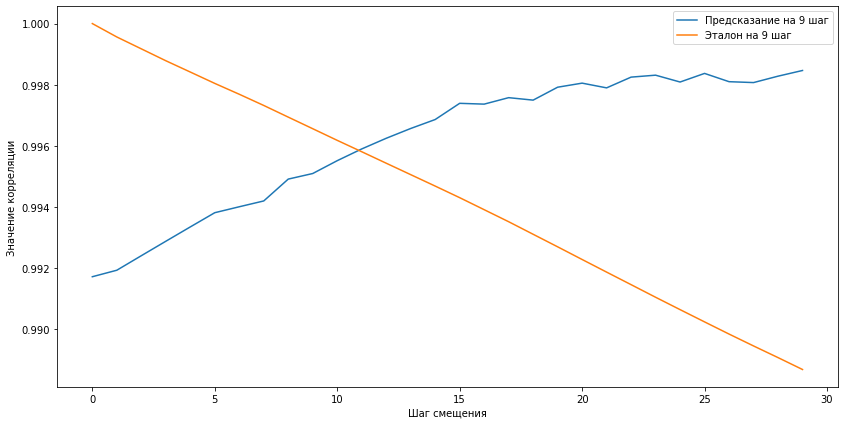

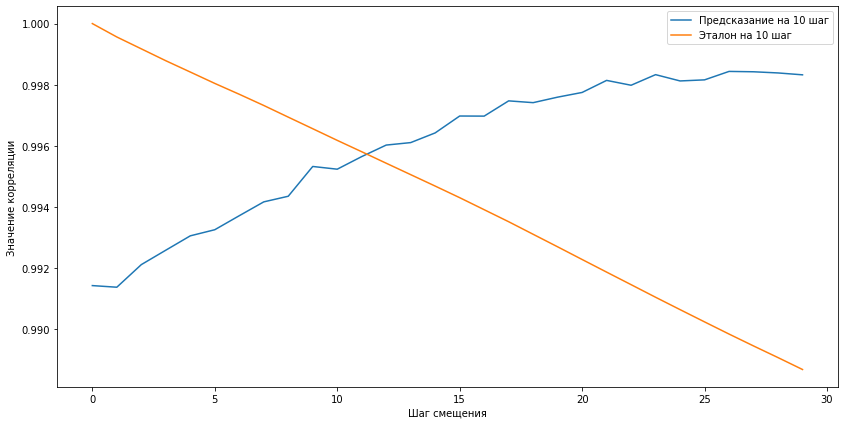

In [ ]:
#Проверяем и Отображаем корреляцию на глубину 30 шагов на каждом канале
showCorr10(10, 30, predVal, yValUnscaled)